# Naïve Bayes: Iris

Vamos a crear un modelo de clasificación con Naïve Bayes para el dataset de Iris.

Importamos las librerías que vamos a utilizar

In [1]:
import numpy as np #operaciones matriciales y con vectores
import pandas as pd #tratamiento de datos
import matplotlib.pyplot as plt #gráficos
from sklearn import naive_bayes, neighbors, datasets, metrics
from sklearn.model_selection import train_test_split #metodo de particionamiento de datasets para evaluación
from sklearn.model_selection import cross_val_score, cross_validate #método para evaluar varios particionamientos de C-V
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold, LeaveOneOut #Iteradores de C-V
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns


## Preparación de los datos

Cargamos los datos y creamos una sola estructura con todos los datos para poder visualizarlos más fácilmente

In [2]:
iris = pd.read_csv('iris.csv')

In [3]:
iris.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


## EDA

1. obtenga las estadisticas descriptivas de iris (describe). (Necesitariamos escalar si tuviesemos un algortimo como KNN?)

In [4]:
iris.describe()

,sepal.length,sepal.width,petal.length,petal.width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


2. Hay datos duplicados?

In [5]:
iris.duplicated().sum()

1

In [6]:
iris.drop_duplicates()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


3. Cree un grafico de barras donde se muestre el conteo de cada especie

<AxesSubplot:xlabel='variety', ylabel='count'>

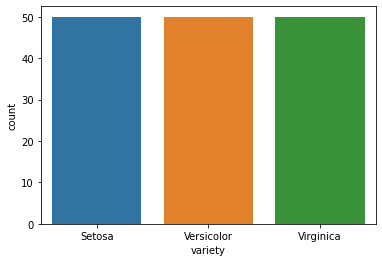

In [7]:
sns.countplot(data = iris, x = 'variety')

4. Genere dos scatter plot cuyas x y 'y'son sepal.width, sepal.length y petal.width, petal.length con la dimension target (es decir hue='target). Que diferencias encuentra entre los distintos tipos de especie? 

<AxesSubplot:xlabel='sepal.width', ylabel='sepal.length'>

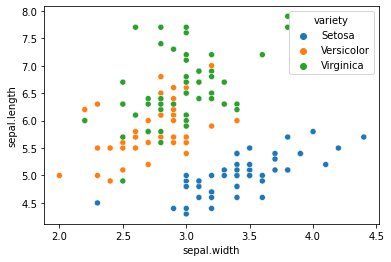

In [8]:
sns.scatterplot(data = iris, x = 'sepal.width', y = 'sepal.length', hue = 'variety')

<AxesSubplot:xlabel='petal.width', ylabel='petal.length'>

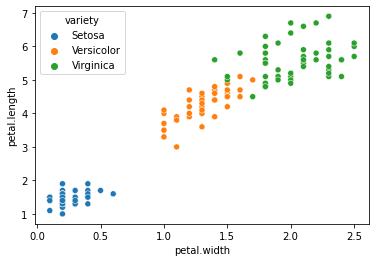

In [9]:
sns.scatterplot(data = iris, x = 'petal.width', y = 'petal.length', hue = 'variety')

5. Cree un heatmap de correlación para todas las variables. Cual es la mas y menos correlacionada?

In [10]:
corr = iris.corr()
corr

,sepal.length,sepal.width,petal.length,petal.width
sepal.length,1.000000,-0.117570,0.871754,0.817941
sepal.width,-0.117570,1.000000,-0.428440,-0.366126
petal.length,0.871754,-0.428440,1.000000,0.962865
petal.width,0.817941,-0.366126,0.962865,1.000000


<AxesSubplot:>

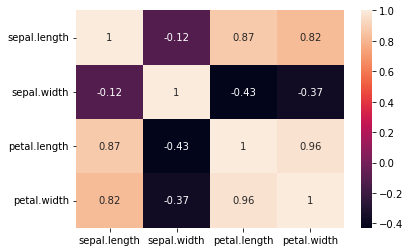

In [11]:
sns.heatmap(corr, annot=True)

6. Cree un diagrama de cajas y bigotes donde las x sean las especies y la y sean todas las variables. Nuestro propósito es analizar las distribuciones, que puede decir sobre ellas en cada variables con respecto a las distintas especies?

<AxesSubplot:xlabel='variety', ylabel='petal.width'>

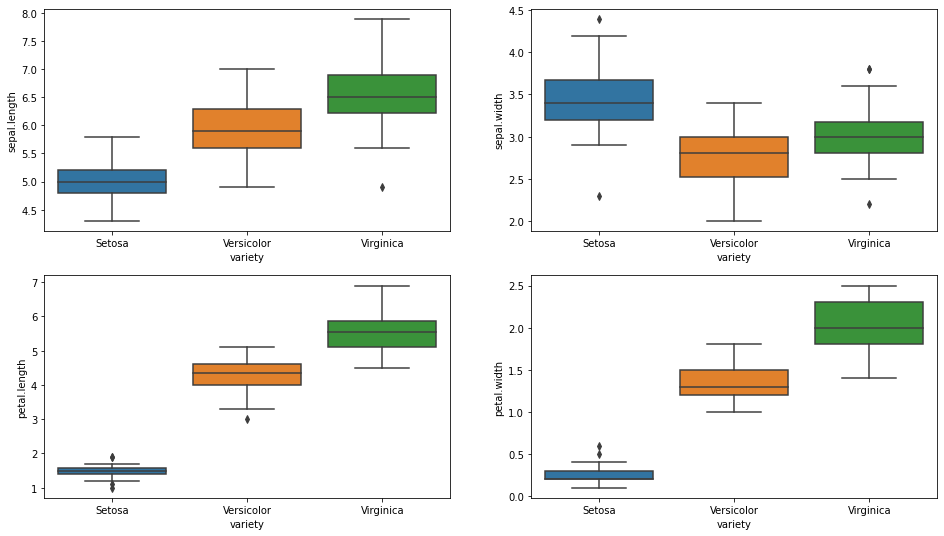

In [12]:
#pista para hacer varios boxplot en cuadrilla
fig, axes = plt.subplots(2, 2, figsize=(16,9))
sns.boxplot(x="variety", y="sepal.length", data=iris, orient="v", ax=axes[0,0])
sns.boxplot(x="variety", y="sepal.width", data=iris, orient="v", ax=axes[0,1])
sns.boxplot(x="variety", y="petal.length", data=iris, orient="v", ax=axes[1,0])
sns.boxplot(x="variety", y="petal.width", data=iris, orient="v", ax=axes[1,1])

7. Cree un kdplot y grafique las variables discriminando por especie (hue). Son diferentes las distribuciones?

<AxesSubplot:xlabel='petal.width', ylabel='Density'>

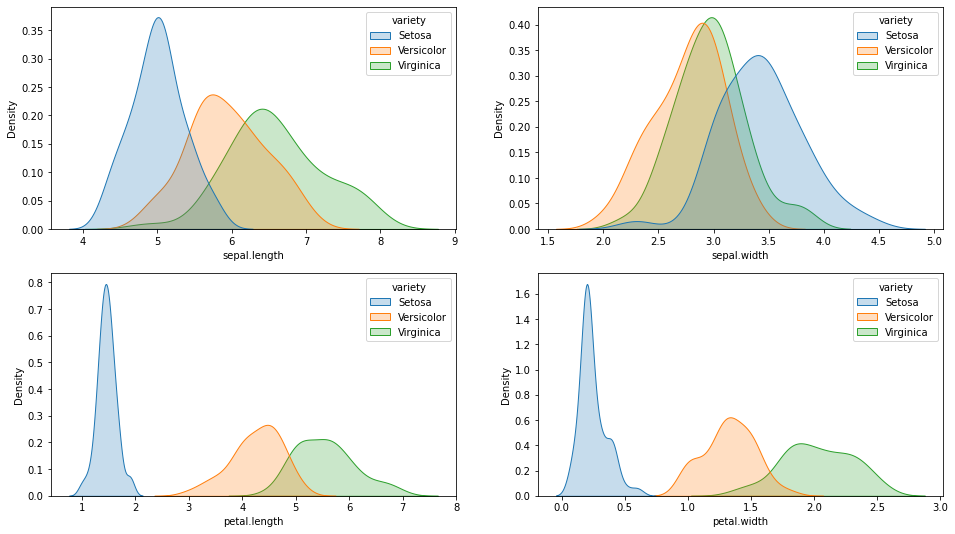

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(16,9))
sns.kdeplot(data = iris, x = 'sepal.length', hue = 'variety', ax=axes[0,0], fill = True)
sns.kdeplot(data = iris, x = 'sepal.width', hue = 'variety', ax=axes[0,1], fill = True)
sns.kdeplot(data = iris, x = 'petal.length', hue = 'variety', ax=axes[1,0], fill = True)
sns.kdeplot(data = iris, x = 'petal.width', hue = 'variety', ax=axes[1,1], fill = True)

## Clasificación a partir de Naïve Bayes

Vamos a utilizar un clasificador [Naïve Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes) que supone una distribución Gaussiana de los datos numéricos, ya que los valores de las variables independientes son continuos.

8. Entrene un modelo de Naive Bayes, recuerde realizar el particionamiento con metodo train_test_split. Luego imprima el reporte de clasificación (classification report) visto en talleres anteriores.

In [14]:
# pista
#gnb = naive_bayes.GaussianNB()
#modeloGNB = gnb.fit(X, y)

In [52]:
variables = iris.loc[:, 'sepal.length': 'petal.width']
X = variables
y = iris['variety']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [54]:
gnb = naive_bayes.GaussianNB()

In [55]:
modeloGNB = gnb.fit(X_train, y_train)

In [56]:
gnb.score(X_test, y_test)

0.9666666666666667

In [57]:
predictions = gnb.predict(X_test)
predictions

array(['Setosa', 'Versicolor', 'Setosa', 'Virginica', 'Virginica',
       'Versicolor', 'Setosa', 'Virginica', 'Setosa', 'Setosa', 'Setosa',
       'Setosa', 'Setosa', 'Setosa', 'Setosa', 'Virginica', 'Setosa',
       'Setosa', 'Versicolor', 'Versicolor', 'Setosa', 'Virginica',
       'Virginica', 'Virginica', 'Virginica', 'Setosa', 'Setosa',
       'Setosa', 'Setosa', 'Virginica'], dtype='<U10')

In [58]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        17
  Versicolor       0.75      1.00      0.86         3
   Virginica       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.92      0.97      0.93        30
weighted avg       0.97      0.97      0.97        30



9. Entrene un modelo de Logistic Regression, recuerde realizar el particionamiento con metodo train_test_split. Luego imprima el reporte de clasificación (classification report) visto en talleres anteriores.

In [59]:
logReg = LogisticRegression(random_state=0).fit(X_train,y_train)

A:\Programar\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [60]:
predictions_lg = logReg.predict(X_test)

In [61]:
logReg.score(X_test, y_test)

0.9666666666666667

In [62]:
print(classification_report(y_test, predictions_lg))

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        17
  Versicolor       0.75      1.00      0.86         3
   Virginica       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.92      0.97      0.93        30
weighted avg       0.97      0.97      0.97        30



10. Entrene un modelo de KNN, recuerde realizar el particionamiento con metodo train_test_split. Es necesario estandarizar los datos? Luego imprima el reporte de clasificación (classification report) visto en talleres anteriores. Trate de buscar el mejor k...

In [73]:
k = 5
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [74]:
predictions_knn = knn_model.predict(X_test)

In [86]:
accurancy1 = knn_model.score(X_test, y_test)

In [76]:
print(classification_report(y_test, predictions_knn))

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        17
  Versicolor       1.00      1.00      1.00         3
   Virginica       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [77]:
k = 13
knn_model2 = KNeighborsClassifier(n_neighbors=k)
knn_model2.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=13)

In [78]:
predictions_knn = knn_model2.predict(X_test)

In [79]:
accurancy_knn = knn_model2.score(X_test, y_test)
accurancy_knn

1.0

In [80]:
print(classification_report(y_test, predictions_knn))

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        17
  Versicolor       1.00      1.00      1.00         3
   Virginica       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [96]:
y_test.value_counts()

Setosa        17
Virginica     10
Versicolor     3
Name: variety, dtype: int64

In [97]:
y_train.value_counts()

Versicolor    47
Virginica     40
Setosa        33
Name: variety, dtype: int64

11. Realice un barplot cuyos ejes x sean los modelos y y el accuracy de estods mismos

In [93]:
dictiona = {
    'knn_model' : accurancy1,
    'knn_model2': accurancy_knn
}
data2 = pd.DataFrame.from_dict(dictiona, orient = 'index', columns = ['Score']).reset_index()
data2

,index,Score
0,knn_model,1.0
1,knn_model2,1.0


<AxesSubplot:xlabel='index', ylabel='Score'>

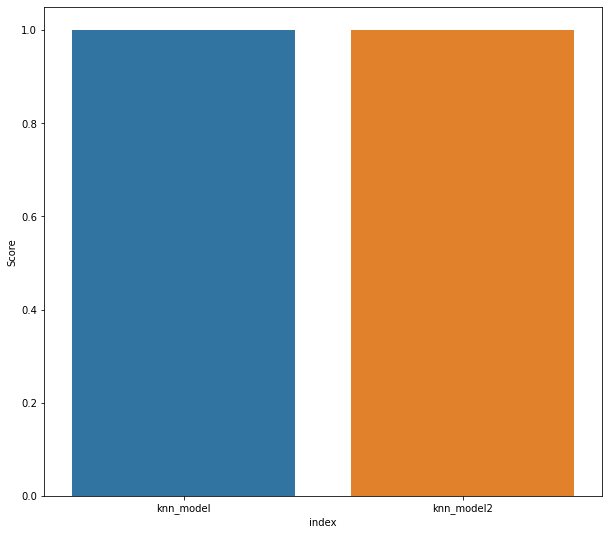

In [95]:
fig, axes = plt.subplots(1, 1, figsize=(10,9))
sns.barplot(data = data2, x = 'index', y = 'Score')

12. Cuál cree que es el mejor modelo? Por qué?

R/

13. Dado el caso que hayan modelos empatados, podemos utilizar CV para realizar un desempate (ya que nuestro dataset es pequeño). Para los modelos que estuvieron muy cerca utilice CV con la metrica accuracy y saque el promedio para comparar

In [35]:
#Pista
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score
#from sklearn.model_selection import cross_val_score
#print(cross_val_score(modelo, X, y, cv=10))
# modelo es nuestro modelo entrenado
# X y y son el dataset completo (sin hacer split), ya que cross_val_score lo hace por nosotros


In [154]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate #En caso de querer imprimir mas de una metrica 

In [101]:
iris

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


In [103]:
X = iris.loc[:,:'petal.width']
y = iris['variety']

In [151]:
accu = cross_val_score(knn_model, X, y, cv=10, scoring='accuracy')

In [152]:
np.mean(accu)

0.9666666666666668

In [153]:
accuracies = cross_val_score(knn_model2, X, y, cv=10, scoring='accuracy')

In [141]:
np.mean(accuracies)

0.9800000000000001

In [155]:
recalls = cross_val_score(knn_model2, X, y, cv=10, scoring='recall_macro') #Etiqueta macro porque hay mas de dos clases

In [143]:
np.mean(recalls)

0.9799999999999999

In [147]:
accuracies2 = cross_val_score(modeloGNB, X, y, cv=10, scoring='accuracy')

In [148]:
np.mean(accuracies2)

0.9533333333333334

In [149]:
recalls2 = cross_val_score(knn_model2, X, y, cv=10, scoring='recall_macro')

In [150]:
np.mean(recalls2)

0.9799999999999999